In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *
from experiments import run_and_eval, run_experiment

In [3]:
nw_generator = NodeWeightGenerator("random")
ew_generator = EdgeWeightGenerator("normal")

rng = np.random.default_rng(32)
G = nx.random_regular_graph(3,10,seed=rng)
print(list(G.neighbors(0)))
nx.draw(G)

rng = np.random.default_rng(32)
rng.choice(G.nodes(), 3)

net = Network(nw_generator, ew_generator, num_nodes=1000, k=20)

seed = 41
net = Network(nw_generator, ew_generator, num_nodes=10, k=2, seed=seed)

np.mean(list(dict(net.graph.degree).values()))

tor = TOREnhancedProtocol(net, 1, 2, broadcast_mode="all", seed=seed)

np.mean(list(dict(net.graph.degree).values()))

tor.tor_network

msg = Message(0)
adv = Adversary(tor, 0.3, seed=seed)

adv.nodes

msg.queue

msg.process(tor, adv)

list(net.graph.neighbors(4))

# Dandelion example with random seed

In [ ]:
seed = 42

In [ ]:
net = Network(nw_generator, ew_generator, num_nodes=100, k=20, seed=seed)
dp = DandelionProtocol(net, 0.5, seed=seed)
adv = Adversary(dp, 0.1, seed=seed)

In [ ]:
messages = [
        Message(sender)
        for sender in net.sample_random_nodes(
            10,
            replace=True,
            use_weights=True,  # random or stake
            exclude=adv.nodes,
        )
]
sim = Simulator(adv, messages=messages, seed=seed, verbose=False)

sim = Simulator(adv, 10, seed=seed, verbose=False)

from data import GoerliTestnet

net = GoerliTestnet()
net = Network(nw_generator, ew_generator, graph=net.graph, seed=seed)
dp = DandelionProtocol(net, 0.5, seed=seed)
#adv_nodes = net.get_central_nodes(int(net.num_nodes*0.1), "degree")
#adv = Adversary(dp, adversaries=adv_nodes)
adv = Adversary(dp, 0.1, seed=seed)
sim = Simulator(adv, 10, seed=seed, verbose=False)

In [ ]:
%%time
_ = sim.run()

In [ ]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

In [ ]:
%%time
evaluator = Evaluator(sim, "first_sent")
print(evaluator.get_report())

In [ ]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

# Unittest in the making

In [55]:
import sys, os, pytest

sys.path.insert(0, "%s/python" % os.getcwd())
import networkx as nx
from network import Network, NodeWeightGenerator, EdgeWeightGenerator
from simulator import Simulator, Evaluator
from message import Message
from protocols import BroadcastProtocol, DandelionProtocol, DandelionPlusPlusProtocol
from adversary import Adversary
import pandas as pd

In [ ]:
### First sent vs First reach test
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84), (2, 3, 1.01)], weight="latency")
print(nx.draw(G, with_labels=True))
net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, seed=44, broadcast_mode="all")
adv = Adversary(protocol, ratio=0.0, adversaries=[3])
print(adv.nodes)
assert 3 in adv.nodes

# start a message from Node 1
msg = Message(1)
receiver_order = [1, 2, 2, 2]
for i, receiver in enumerate(receiver_order):
    msg.process(adv)
    print(i, receiver, msg.history)
    assert receiver in msg.history
    # assert len(msg.history) == i + 1

In [ ]:
sim = Simulator(adv, 1, True)
sim.run(1.0)
for estimator in ["first_reach", "first_sent"]:
    evaluator = Evaluator(sim, estimator)
    results = [
        evaluator.exact_hits,
        evaluator.ranks,
        evaluator.inverse_ranks,
        evaluator.entropies,
    ]
    for i in results:
        print(estimator, i)

In [ ]:
from experiments import run_and_eval

rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84), (2, 3, 0.85)], weight="latency")

net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, "all", seed=44)
adv = Adversary(protocol, ratio=0.0, adversaries=[3])
sim = Simulator(adv, 1, messages=[Message(1)])

assert 3 in sim.adversary.nodes
assert len(sim.messages)==1

new_reports = run_and_eval(sim)

sim.messages[0].flush_queue(sim.adversary)

print(new_reports)
assert sim.adversary.predict_msg_source("first_sent").iloc[0][1]==1
assert sim.adversary.predict_msg_source("first_reach").iloc[0][2]==1

sim.adversary.predict_msg_source("first_reach")

In [114]:
### Dandelion adversary in the making
H = nx.complete_graph(10)
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
SEED = 43
net = Network(
    rnd_node_weight, EdgeWeightGenerator("unweighted"), graph=H, seed=SEED
)
protocol = DandelionProtocol(net, 0.3, broadcast_mode="all", seed=SEED+2)
adv = Adversary(protocol, 0.3)
sim = Simulator(adv, 1, messages=[Message(0)])

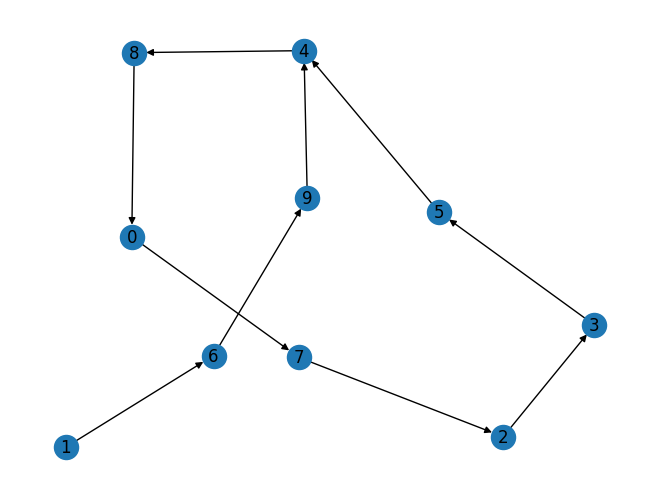

In [115]:
nx.draw(protocol.anonymity_graph, with_labels = True)

In [116]:
adv.nodes

[9, 6, 7]

In [117]:
sim.run(0.9, max_trials=50)

[0.9]

In [148]:
probabilities = {}
for i in adv.captured_events:
    probabilities[i.mid] = [0 for j in range(protocol.network.num_nodes)]
    
    heardFromStemmingPhase = []
    firstBroadcaster = -1
    
    ## Who is the first node that reports to the adversary in the stem phase?
    if not i.protocol_event.spreading_phase and (i.protocol_event.sender not in heardFromStemmingPhase) and (i.protocol_event.sender not in adv.nodes):
        heardFromStemmingPhase.append(i.protocol_event.sender)
        continue
    ## The first broadcaster the adversary knows about
    if i.protocol_event.spreading_phase and firstBroadcaster==-1:
        firstBroadcaster = i.protocol_event.sender
    
    print("Stemming Phase", heardFromStemmingPhase)
    shortestPathLength = sys.maxsize
    shortestAdvPath = []
    for k in adv.nodes:
        if heardFromStemmingPhase==[]:
            path = nx.shortest_path(protocol.anonymity_graph,k,firstBroadcaster)
        else:
            path = nx.shortest_path(protocol.anonymity_graph,k,heardFromStemmingPhase[0])   
        if len(path) < shortestPathLength and len(path)!=2:
            shortestAdvPath = path
            shortestPathLength = len(path)
    
    print(shortestAdvPath)
    probSum = 0 # See Equation 2 here: https://arxiv.org/pdf/2201.11860.pdf
    for node in range(shortestPathLength):   
        ## The broadcaster node is not the originator, since in Dandelion the message should have at least 1 hop
        ## We also want to exclude adversarial nodes
        if node!=0 and shortestAdvPath[shortestPathLength-node-1] not in adv.nodes:
            probabilities[i.mid][shortestAdvPath[shortestPathLength-node-1]]=pow(protocol.spreading_proba,node)
            probSum+=pow(protocol.spreading_proba,node)
            print(probSum)
    print(adv.nodes,probSum)
    for j in range(len(probabilities[i.mid])):
        probabilities[i.mid][j]/=probSum
    break
deanonProbas = pd.DataFrame.from_dict(probabilities, orient='index')
print(deanonProbas)

Stemming Phase []
[9, 4, 8, 0, 7, 2]
0.09
0.11699999999999999
0.1251
[9, 6, 7] 0.1251
                                         0    1    2    3         4    5    6  \
1ec8b81adade4523a259b6a19e603c6e  0.719424  0.0  0.0  0.0  0.064748  0.0  0.0   

                                    7         8    9  
1ec8b81adade4523a259b6a19e603c6e  0.0  0.215827  0.0  
